In [4]:
import pandas as pd
import networkx as nx 
import numpy as np
from tqdm import tqdm
import random 

def create_network(df):
   """
   Converts a DataFrame with source nodes, target nodes and edge weights
   into a directed NetworkX graph.

   Parameters:
   ----------
   df : pandas.DataFrame
       A DataFrame with the following columns:
       - 'source': Source node (str or int)
       - 'target': Target node (str or int)
       - 'weight': Weight of the directed edge (int or float)

   Returns:
   -------
   G : networkx.DiGraph
       A directed graph where each edge from 'source' to 'target' has an associated weight.
   """
   
   G = nx.DiGraph() # Initialize a directed graph

   # Iterate through each row to add edges with weights
   for _, row in df.iterrows():
       source = row['source']
       target = row['target']
       weight = row['weight']
       G.add_edge(source, target, weight=weight)

   return G

'''
#Generate random dataframe to check the code:
df = pd.DataFrame({
    'source': np.random.randint(0, 500, size=1000),
    'target': np.random.randint(0, 500, size=1000),
    'weight': np.random.rand(1000)
})

#Built in networkx
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph(), edge_key=None)

#function check:
G = create_network(df) #quick enough
'''


"\n#Generate random dataframe to check the code:\ndf = pd.DataFrame({\n    'source': np.random.randint(0, 500, size=1000),\n    'target': np.random.randint(0, 500, size=1000),\n    'weight': np.random.rand(1000)\n})\n\n#Built in networkx\nG = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph(), edge_key=None)\n\n#function check:\nG = create_network(df) #quick enough\n"

In [5]:
df = pd.read_csv(r'./Weighted_network_data.csv')
G = create_network(df)

#network analysis
disconnected_edges = []
for component in nx.weakly_connected_components(G):  # for directed graph G
    subgraph = G.subgraph(component)
    if subgraph.number_of_nodes() == 2 and subgraph.number_of_edges() == 1:
        disconnected_edges.extend(subgraph.edges())

#len(disconnected_edges) #266 

largest_cc_nodes = max(nx.weakly_connected_components(G)) #5165 nodes
largest_cc_subgraph = G.subgraph(largest_cc_nodes).copy()

##### Collect the paths: 

def precompute_transitions(G):
    """
    Precompute neighbor lists and edge weights for all nodes in the graph.
    Returns a dictionary: node -> (neighbors, weights)
    """
    transitions = {}
    for node in G.nodes():
        neighbors = list(G._succ[node])
        if neighbors:
            weights = [G[node][nbr].get('weight', 1.0) for nbr in neighbors]
            transitions[node] = (neighbors, weights)
    return transitions

def collect_paths(G, source, target, transitions, num_paths=1000, max_steps=100, random_seed=None):
    """
    Perform random walks from source to target using precomputed transitions.

    Parameters:
    -----------
    G : networkx.DiGraph
    source : node
    target : node
    transitions : dict
        Precomputed neighbors and weights per node.
    num_paths : int
    max_steps : int
    random_seed : int or None

    Returns:
    --------
    paths : list of list of nodes
    """
    rng = random.Random(random_seed)
    paths = []

    for _ in range(num_paths):
        path = [source]
        current = source
        steps = 0

        while current != target and steps < max_steps:
            if current not in transitions:
                break  # dead end
            neighbors, weights = transitions[current]
            current = rng.choices(neighbors, weights=weights, k=1)[0]
            path.append(current)
            steps += 1

        if path[-1] == target:
            paths.append(path)

    return paths

# === Main run ===

transitions = precompute_transitions(largest_cc_subgraph)

paths = {}
for source in tqdm(largest_cc_subgraph.nodes(), desc="Processing sources"):
    for target in largest_cc_subgraph.nodes():
        if source != target and nx.has_path(largest_cc_subgraph, source, target):  # Optional: skip if unreachable
            paths[(source, target)] = collect_paths(
                largest_cc_subgraph, source, target, transitions, num_paths=1000, max_steps=100
            )

Processing sources:  15%|█▌        | 792/5165 [01:10<06:29, 11.22it/s]


KeyboardInterrupt: 

ValueError: 'Buurow village' is not in list

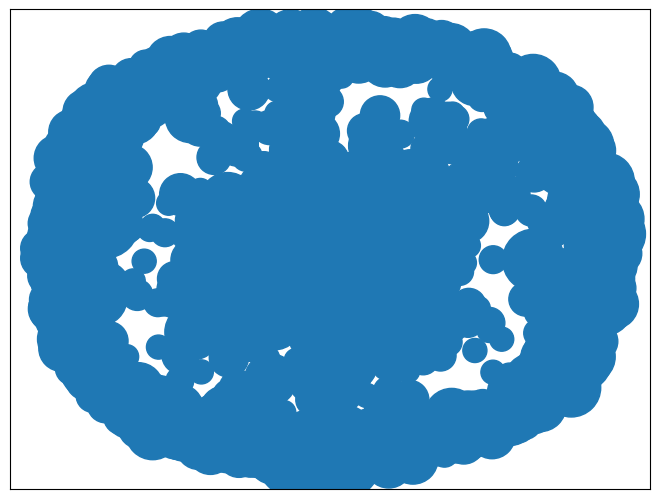

In [12]:
F = largest_cc_subgraph

# val_map = {'A': 1.0,
#            'D': 0.5714285714285714,
#            'H': 0.0}

# values = [val_map.get(node, 0.25) for node in G.nodes()]

# nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)

nodes = [n for n in F.nodes() if F.degree(n) > 2]
node_degrees = [F.degree(n) for n in nodes]

nx.draw(F, nodelist=nodes, node_size=[v * 100 for v in node_degrees])

In [11]:
len(nodes)

1748

In [1]:
import graph_tool.all as gt
import matplotlib.cm

gt.seed_rng(47)

g = gt.collection.ns["foodweb_baywet"]

sargs = dict(recs=[g.ep.weight],
             rec_types=["real-exponential"])
state = \
    gt.minimize_nested_blockmodel_dl(g,
                                     state_args=sargs)

state.draw(edge_color=gt.prop_to_size(g.ep.weight,
                                      power=1,
                                      log=True),
           ecmap=(matplotlib.cm.inferno, .6),
           eorder=g.ep.weight,
           edge_pen_width=gt.prop_to_size(g.ep.weight,
                                          1, 4,
                                          power=1,
                                          log=True),
           edge_gradient=[]);

ModuleNotFoundError: No module named 'graph_tool'